<a href="https://colab.research.google.com/github/ThomasWong-ST/Intro-to-RL/blob/main/Policy_Gradient_Methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Short Corridor with Switched Actions


In [1]:
import numpy as np

In [2]:
LEFT, RIGHT = 0, 1
ACTIONS = [LEFT, RIGHT]

class ShortCorridorSwitched:
    """
    Short corridor with switched actions (Sutton & Barto, Ch.13, Example 13.1)

    Layout (indices):
        start=0  ->  1 (switched)  ->  2  ->  goal=3 (terminal)

    Rewards:
        -1 per step until reaching the terminal (index 3). 0 at terminal transition.

    Dynamics:
      - Normal states (0 and 2): LEFT=-1, RIGHT=+1 (with boundary clip at 0 and 3).
      - Switched state (1):      LEFT acts as +1 (moves right), RIGHT acts as -1 (moves left).
      - From state 0, LEFT keeps you at 0 (hit the wall) and costs -1 as usual.
    """
    def __init__(self):
        self.n_cols = 4                 # 0,1,2 non-terminal, 3 is terminal
        self.start = 0
        self.goal = 3
        self.step_cost = -1.0
        self.state = None

    def reset(self):
        self.state = self.start
        return self.state

    def step(self, action):
        s = self.state
        assert action in (LEFT, RIGHT)

        # effective move depends on whether we are in the switched middle state (1)
        if s == 1:
            # actions reversed in the middle cell
            delta = +1 if action == LEFT else -1
        else:
            # normal behavior
            delta = -1 if action == LEFT else +1

        ns = np.clip(s + delta, 0, self.goal)  # clip to [0,3]
        done = (ns == self.goal)
        reward = 0.0 if done else self.step_cost

        self.state = ns
        return ns, reward, done, {}

    # --- convenience properties for FA/control code ---
    @property
    def nS(self):  # number of states (including terminal index for convenience)
        return self.n_cols

    @property
    def nA(self):  # number of actions
        return len(ACTIONS)


In [3]:
'''def policy_softmax(s, theta, rng=None):
    rng = np.random.default_rng() if rng is None else rng
    # action-only features, order RIGHT(1), LEFT(0)
    h = np.array([theta @ np.array([1.,0.]),   # right
                  theta @ np.array([0.,1.])])  # left
    z = h - h.max()                 # stability
    p = np.exp(z) / np.exp(z).sum() # probs [p_right, p_left]
    a = 1 if rng.random() < p[0] else 0
    return a, p

def grad_log_pi(theta, a, p):
    x_right = np.array([1.,0.]); x_left = np.array([0.,1.])
    x_a = x_right if a==1 else x_left
    x_bar = p[0]*x_right + p[1]*x_left
    return x_a - x_bar'''

In [3]:
def policy_softmax(s, theta, rng=None):
    rng = np.random.default_rng() if rng is None else rng
    # logits: h_right = θ·[1,0], h_left = θ·[0,1]
    h = np.array([theta[0], theta[1]])          # [h_right, h_left]
    z = h - h.max()                             # stable softmax
    p = np.exp(z); p /= p.sum()                 # p = [P(RIGHT), P(LEFT)]
    a = RIGHT if rng.random() < p[0] else LEFT  # sample action
    return a, p

def grad_log_pi(theta, a, p):
    # ∇θ log π(A=a) = x(a) - Σ_b π(b) x(b), with x(right)=[1,0], x(left)=[0,1]
    if a == RIGHT:
        return np.array([1.0 - p[0],      -p[1]])
    else:  # LEFT
        return np.array([     -p[0], 1.0 - p[1]])

##REINFORCE Algorithm

In [4]:
def returns_from_rewards(rewards, gamma=1.0):
    """Compute G_t (return-to-go) for a single episode."""
    G = np.zeros(len(rewards), dtype=float)
    g = 0.0
    for t in reversed(range(len(rewards))):
        g = rewards[t] + gamma * g
        G[t] = g
    return G

def REINFORCE(env, theta, policy, policy_gradient, alpha=0.05, gamma=1.0, max_steps=1000, rng=None):
    """
    Runs ONE episode under current theta and applies REINFORCE updates:
        theta <- theta + alpha * G_t * ∇_θ log π(A_t | S_t)
    Returns: updated theta, episode length
    """
    rng = np.random.default_rng() if rng is None else rng

    # --- generate episode ---
    states, actions, rewards = [], [], []
    s = env.reset()
    done = False
    steps = 0
    probs_cache = []

    while not done and steps < max_steps:
        a, probs = policy(s, theta, rng)  # you wrote this policy earlier
        s_next, r, done, _ = env.step(a)
        states.append(s); actions.append(a); rewards.append(r); probs_cache.append(probs)
        s = s_next; steps += 1

    # --- compute returns and update ---
    G = returns_from_rewards(rewards, gamma=gamma)
    for t in range(len(actions)):
        grad = policy_gradient(theta, actions[t], probs_cache[t])  # ∇ log π(A_t|S_t)
        theta = theta + alpha * G[t] * grad

    return theta, steps

In [95]:
env = ShortCorridorSwitched()
theta = np.zeros(2, float)                 # start at [0, 0]
REINFORCE(env, theta, policy_softmax, grad_log_pi,
                             alpha=0.05, gamma=1.0, max_steps=1000, rng=None)

(array([ 0.8, -0.8]), 13)

In [8]:
n_episodes = 3000

env = ShortCorridorSwitched()
theta = [0,0]
all_episode_lengths = []
all_theta_values = []
prob_right_values = []

for ep in range(n_episodes):
    theta_prime, episode_len_prime = REINFORCE(env, theta, policy_softmax, grad_log_pi,
                                 alpha=0.0002, gamma=1.0, max_steps=1000, rng=None)
    p_right = np.exp(theta_prime[0]) / (np.exp(theta_prime[0]) + np.exp(theta_prime[1]))
    prob_right_values.append(p_right)
    all_episode_lengths.append(episode_len_prime)
    all_theta_values.append(theta_prime)
    theta, episode_len = theta_prime, episode_len_prime
    #print(theta, episode_len)


#print(f"Final theta: {theta}")
#print(f"Average episode length over {n_episodes} episodes: {np.mean(all_episode_lengths)}")

In [13]:
print(prob_right_values)

[np.float64(0.5000999999986667), np.float64(0.5007502094370251), np.float64(0.5071346104520605), np.float64(0.5070867605147155), np.float64(0.5070388960953998), np.float64(0.5071430984703471), np.float64(0.5062254067077253), np.float64(0.5046036126671007), np.float64(0.5045549978291008), np.float64(0.5042850819161009), np.float64(0.5065003823154296), np.float64(0.5068068284124868), np.float64(0.5066670640342565), np.float64(0.5065270890031136), np.float64(0.5068335613652886), np.float64(0.5079209087627363), np.float64(0.5075828714114016), np.float64(0.5074442770231942), np.float64(0.5072336537373979), np.float64(0.5079595271691463), np.float64(0.5080642759826137), np.float64(0.5080167075697243), np.float64(0.5086833565816593), np.float64(0.4953150613121228), np.float64(0.4949440143154258), np.float64(0.4934835391416896), np.float64(0.4950598716497146), np.float64(0.49625603816978836), np.float64(0.49635378645359474), np.float64(0.4968837079942669), np.float64(0.49604136878728294), np.f

#Actor-Critic Algorithm

In [11]:
def actor_critic(env, theta, v, alpha=0.01, beta=0.05, gamma=1.0,
                         max_steps=1000, rng=None):
    """
    One episodic TD(0) actor–critic pass.

    θ_{t+1} = θ_t + α δ_t ∇θ log π(A_t|S_t)
    v_{t+1}(S_t) = v_t(S_t) + β δ_t

    Returns: updated (theta, v), episode length, episode return G0
    """
    rng = np.random.default_rng() if rng is None else rng
    s = env.reset()
    done = False
    steps = 0
    G0 = 0.0  # total return of episode
    while not done and steps < max_steps:
      #Sample an initial trajectory from the policy
      a,p = policy_softmax(s, theta, rng)
      s_next, r, done, _ = env.step(a)
      G0 += r #Note down the return to do plots later
      if done:
        delta = (r - v[s])
      else:
        delta = (r + gamma * v[s_next] - v[s])

      v[s] = beta*delta

      theta += alpha * delta * grad_log_pi(theta, a, p)

      s = s_next
      steps += 1
    return theta, v, steps, G0

In [19]:
env = ShortCorridorSwitched()
theta = np.zeros(2, float)          # actor params
v = np.zeros(env.nS, float)         # critic params (one value per state)
rng = np.random.default_rng(123)

n_episodes = 2000
lens = []
returns = []

for ep in range(n_episodes):
    theta, v, steps, G0 = actor_critic(
        env, theta, v,
        alpha=0.0002,   # actor step size
        beta=0.0002,     # critic step size (often larger)
        gamma=1.0,
        max_steps=1000,
        rng=rng
    )
    lens.append(steps)
    returns.append(G0)

    if (ep + 1) % 200 == 0:
        # compute current P(RIGHT)
        h = np.array([theta[0], theta[1]])
        z = h - h.max()
        p = np.exp(z); p /= p.sum()
        p_right = p[0]
        avg_len = np.mean(lens[-100:])
        print(f"ep {ep+1:4d} | avg steps(last100)={avg_len:6.2f} | P(RIGHT)={p_right:5.3f} | θ={theta}")


ep  200 | avg steps(last100)= 10.94 | P(RIGHT)=0.507 | θ=[ 0.0149171 -0.0149171]
ep  400 | avg steps(last100)= 13.01 | P(RIGHT)=0.518 | θ=[ 0.03564974 -0.03564974]
ep  600 | avg steps(last100)= 11.56 | P(RIGHT)=0.526 | θ=[ 0.05133642 -0.05133642]
ep  800 | avg steps(last100)= 12.80 | P(RIGHT)=0.536 | θ=[ 0.07221637 -0.07221637]
ep 1000 | avg steps(last100)= 12.51 | P(RIGHT)=0.545 | θ=[ 0.0896731 -0.0896731]
ep 1200 | avg steps(last100)= 12.05 | P(RIGHT)=0.553 | θ=[ 0.10554414 -0.10554414]
ep 1400 | avg steps(last100)= 12.32 | P(RIGHT)=0.561 | θ=[ 0.12250718 -0.12250718]
ep 1600 | avg steps(last100)= 11.53 | P(RIGHT)=0.568 | θ=[ 0.13616755 -0.13616755]
ep 1800 | avg steps(last100)= 12.18 | P(RIGHT)=0.575 | θ=[ 0.15099892 -0.15099892]
ep 2000 | avg steps(last100)= 12.67 | P(RIGHT)=0.581 | θ=[ 0.16261887 -0.16261887]


# Task
Analyze the performance of the REINFORCE algorithm in the `ShortCorridorSwitched` environment by running experiments with varying numbers of training episodes. For each `n_episodes` value, repeat the experiment 30 times, re-initializing the policy parameters (`theta`) for each repetition. Record the episode lengths from each run. After all repetitions, calculate and plot the average episode length against the number of training episodes. Finally, summarize how the average episode length changes with the number of training episodes.

## Setup Experiment Parameters

### Subtask:
Define the list of episode counts to test and the number of repetitions for each.


**Reasoning**:
The user wants to define experiment parameters and initialize a list for storing results. I will define `n_episodes_to_test`, `n_repetitions`, `alpha`, `gamma`, and `all_avg_episode_lengths` in a code block.



In [36]:
n_episodes_to_test = np.arange(1, 1000, 10)
n_repetitions = 30
alpha = 0.0002
gamma = 1.0
all_avg_episode_lengths = []

print(f"Episode counts to test: {n_episodes_to_test}")
print(f"Number of repetitions: {n_repetitions}")
print(f"Learning rate (alpha): {alpha}")
print(f"Discount factor (gamma): {gamma}")
print("Initialized all_avg_episode_lengths list.")

Episode counts to test: [  1  11  21  31  41  51  61  71  81  91 101 111 121 131 141 151 161 171
 181 191 201 211 221 231 241 251 261 271 281 291 301 311 321 331 341 351
 361 371 381 391 401 411 421 431 441 451 461 471 481 491 501 511 521 531
 541 551 561 571 581 591 601 611 621 631 641 651 661 671 681 691 701 711
 721 731 741 751 761 771 781 791 801 811 821 831 841 851 861 871 881 891
 901 911 921 931 941 951 961 971 981 991]
Number of repetitions: 30
Learning rate (alpha): 0.0002
Discount factor (gamma): 1.0
Initialized all_avg_episode_lengths list.


**Reasoning**:
The next step is to implement the experimental loop. I will iterate through each value in `n_episodes_to_test`, and for each of these, run `n_repetitions` experiments. In each repetition, `theta` will be re-initialized to zeros, and the REINFORCE algorithm will be run. The episode lengths from each run will be stored in a list for later averaging.



In [ ]:
all_results = {}

for n_episodes in n_episodes_to_test:
    repetition_episode_lengths = []
    print(f"\nRunning experiment for {n_episodes} episodes...")
    for rep in range(n_repetitions):
        env = ShortCorridorSwitched()
        theta = np.zeros(2, float) # Re-initialize theta for each repetition
        episode_lengths_this_repetition = []

        for ep in range(n_episodes):
            theta, episode_len = REINFORCE(env, theta, policy_softmax, grad_log_pi,
                                         alpha=alpha, gamma=gamma, max_steps=1000, rng=None)
            episode_lengths_this_repetition.append(episode_len)

        # After n_episodes for this repetition, store the average length
        repetition_episode_lengths.append(np.mean(episode_lengths_this_repetition))
        print(f"  Repetition {rep+1}/{n_repetitions} finished. Average episode length: {np.mean(episode_lengths_this_repetition):.2f}")

    all_results[n_episodes] = repetition_episode_lengths
    avg_of_reps = np.mean(repetition_episode_lengths)
    all_avg_episode_lengths.append(avg_of_reps)
    print(f"Finished {n_episodes} episodes tests. Average episode length over {n_repetitions} repetitions: {avg_of_reps:.2f}")

print("\nExperiment complete. Stored results in all_results and all_avg_episode_lengths.")

**Reasoning**:
I need to visualize the results by plotting the average episode length against the number of training episodes. I will use `matplotlib.pyplot` for this.



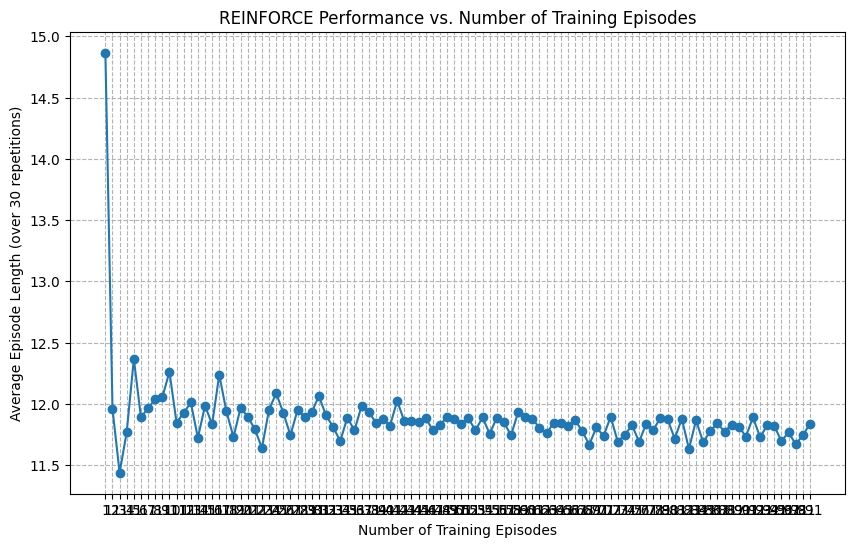

Plot generated showing average episode length vs. number of training episodes.


In [38]:
import matplotlib.pyplot as plt

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(n_episodes_to_test, all_avg_episode_lengths, marker='o', linestyle='-')
#plt.xscale('log') # Use a log scale for the x-axis as n_episodes vary widely
plt.xticks(n_episodes_to_test, labels=[str(x) for x in n_episodes_to_test]) # Set custom x-tick labels
plt.xlabel('Number of Training Episodes')
plt.ylabel('Average Episode Length (over 30 repetitions)')
plt.title('REINFORCE Performance vs. Number of Training Episodes')
plt.grid(True, which="both", ls="--", c='0.7')
plt.show()

print("Plot generated showing average episode length vs. number of training episodes.")